In [1]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from lmfit import Parameters, Minimizer
from model_functions import gaussian_model, get_err_lsq, build_normal_volsurface
display(HTML("<style>.container {width:95% !important;}</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

In [2]:
ycrv = pd.read_csv('IR_curve_EUR_2019_07_31.csv')
vols = pd.read_csv('normal_volsurface_2019_07_31.csv')

vols = vols.rename(columns = {'expiry/tenor':'expiry'}).set_index('expiry').rename_axis('tenor', axis = 1)
vols = vols.stack().reset_index().rename(columns = {0:'sigma_normal'})
vols['tenor'] = vols['tenor'].astype(float) 
vols['TN'] = vols.eval('expiry+tenor')
vols = vols.query('expiry >=1 and tenor >=1').rename(columns = {'expiry':'T0'})
vols = vols[['T0', 'TN', 'tenor', 'sigma_normal']]

## Standard model parametrization
In the standard parametrization we have a 5-tuple parmeter set $({\varkappa _1},{\varkappa _2},{\sigma _1},{\sigma _2},\rho )$. The volatility matrix is then given as
\begin{equation}
\sigma  = \left( {\begin{array}{*{20}{c}}
{{\sigma _{11}}}&{{\sigma _{12}}}\\
{{\sigma _{21}}}&{{\sigma _{22}}}
\end{array}} \right) = \left( {\begin{array}{*{20}{c}}
{{\sigma _1}}&{\rho {\sigma _2}}\\
0&{\sqrt {1 - {\rho ^2}} {\sigma _2}}
\end{array}} \right).
\end{equation}
This defines a $\mathbb{Q}$-dynamics of $x$ as 
\begin{eqnarray}
d{x_1}(t) &=& \left( {{v_1}(t) - {\varkappa _1}{x_1}(t)} \right)dt + {\sigma _{11}}d{W_1}(t) + {\sigma _{21}}d{W_2}(t) = \left( {{v_1}(t) - {\varkappa _1}{x_1}(t)} \right)dt + {\sigma _1}d{W_1}(t)\\
d{x_2}(t) &=& \left( {{v_2}(t) - {\varkappa _2}{x_2}(t)} \right)dt + {\sigma _{12}}d{W_1}(t) + {\sigma _{22}}d{W_2}(t) = \left( {{v_2}(t) - {\varkappa _2}{x_2}(t)} \right)dt + \rho {\sigma _2}d{W_1}(t) + \sqrt {1 - {\rho ^2}} {\sigma _2}d{W_2}(t).
\end{eqnarray}

In [ ]:
params = Parameters()
params.add_many(('kappa1', 0.15,  True, 0.0001, 0.6, None, None),
                ('kappa2', 0.4,  True, 0.0001, 0.6, None, None),
                ('sigma1', 0.05,  True, 0.0001, 0.1, None, None),
                ('sigma2', 0.05, True, 0.0001, 0.1, None, None),
                ('rho',   -0.95,   True,-0.9999,0.9999, None, None))
fitter = Minimizer(lambda params: get_err_lsq(params, vols, 0.5, ycrv['maturity'], ycrv['value'], ycrv_freq = 9999), params = params).minimize(method = 'least_squares')

In [105]:
params = {'kappa1': 0.047942,'kappa2': 0.070179,'sigma1': 0.035285,'sigma2': 0.035644, 'rho': -0.990690}
vols_model = build_normal_volsurface(params, vols['T0'].drop_duplicates(), vols['tenor'].drop_duplicates(), 0.5,ycrv['maturity'], ycrv['value'], ycrv_freq = 9999)

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [02:00<00:00,  1.87it/s]


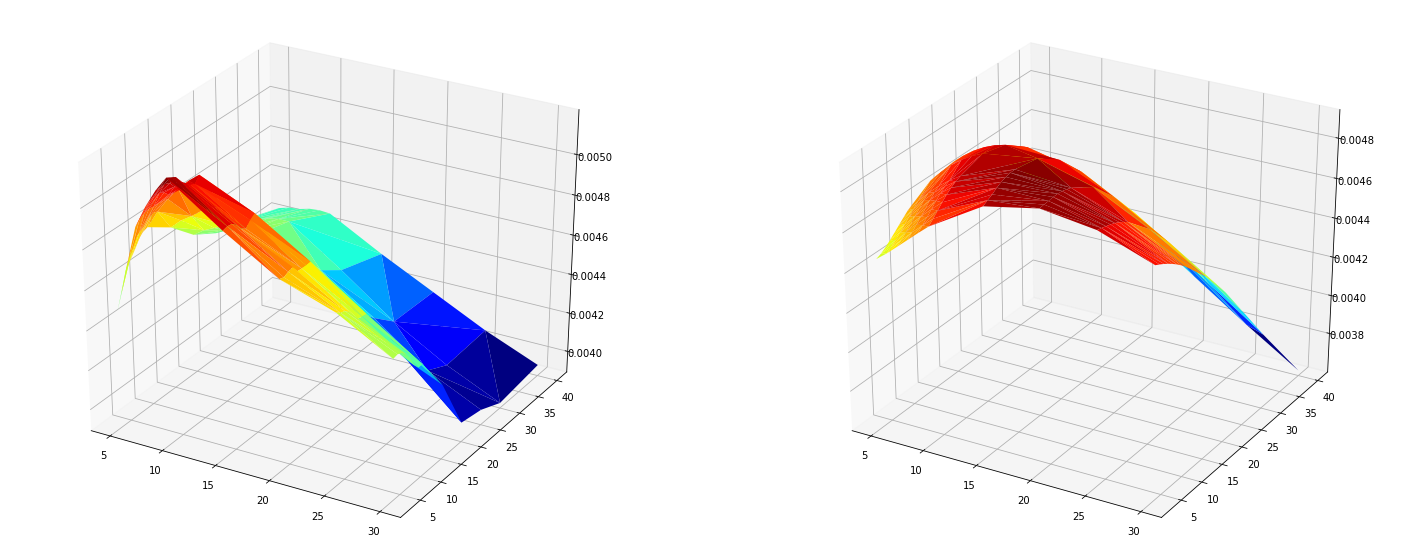

In [122]:
orig_volsurface  = vols.rename(columns = {'T0':'expiry'}).query('expiry>=5 and tenor >= 3')
model_volsurface = vols_model.stack().reset_index().rename(columns = {0:'sigma_normal'}).query('expiry>=5 and tenor >= 3')

fig = plt.figure(figsize = (25, 10))
ax  = fig.add_subplot(121, projection='3d')
ax.plot_trisurf(orig_volsurface['expiry'],  orig_volsurface['tenor'], orig_volsurface['sigma_normal'], cmap=cm.jet, linewidth=0.2)
ax  = fig.add_subplot(122, projection='3d')
ax.plot_trisurf(model_volsurface['expiry'], model_volsurface['tenor'], model_volsurface['sigma_normal'], cmap=cm.jet, linewidth=0.2)

## Hull-White 2-factor model parametrization
It can be shown that the Hull-White 2-factor is equivalent to a 2-factor gaussian model with a 5-tuple parameter set $({\varkappa _r},{\varkappa _\varepsilon },{\sigma _r},{\sigma _\varepsilon },\rho )$ such that
\begin{equation}
\sigma  = \left( {\begin{array}{*{20}{c}}
{{\sigma _{11}}}&{{\sigma _{12}}}\\
{{\sigma _{21}}}&{{\sigma _{22}}}
\end{array}} \right) = \left( {\begin{array}{*{20}{c}}
{{\sigma _r} - \rho {\sigma _\varepsilon }\frac{{{\varkappa_r}}}{{{\varkappa_r} - {\varkappa_\varepsilon }}}}&{ - {\sigma _\varepsilon }\sqrt {1 - {\rho ^2}} \frac{{{\varkappa_r}}}{{{\varkappa_r} - {\varkappa_\varepsilon }}}}\\
{\rho {\sigma _\varepsilon }\frac{{{\varkappa_r}}}{{{\varkappa_r} - {\varkappa_\varepsilon }}}}&{{\sigma _\varepsilon }\sqrt {1 - {\rho ^2}} \frac{{{\varkappa_r}}}{{{\varkappa_r} - {\varkappa_\varepsilon }}}}
\end{array}} \right)
\end{equation}
This defines a $\mathbb{Q}$-dynamics of $x$ as
\begin{eqnarray}
d{x_1}(t) &=& \left( {{v_1}(t) - {\varkappa _1}{x_1}(t)} \right)dt + {\sigma _{11}}d{W_1}(t) + {\sigma _{21}}d{W_2}(t) = \left( {{v_1}(t) - {\varkappa _r}{x_1}(t)} \right)dt + \left( {{\sigma _r} - \rho {\sigma _\varepsilon }\frac{{{\varkappa _r}}}{{{\varkappa _r} - {\varkappa _\varepsilon }}}} \right)d{W_1}(t) + \rho {\sigma _\varepsilon }\frac{{{\varkappa _r}}}{{{\varkappa _r} - {\varkappa _\varepsilon }}}d{W_2}(t)\\
d{x_2}(t) &=& \left( {{v_2}(t) - {\varkappa _2}{x_2}(t)} \right)dt + {\sigma _{12}}d{W_1}(t) + {\sigma _{22}}d{W_2}(t) = \left( {{v_2}(t) - {\varkappa _\varepsilon }{x_2}(t)} \right)dt - {\sigma _\varepsilon }\sqrt {1 - {\rho ^2}} \frac{{{\varkappa _r}}}{{{\varkappa _r} - {\varkappa _\varepsilon }}}d{W_1}(t) + {\sigma _\varepsilon }\sqrt {1 - {\rho ^2}} \frac{{{\varkappa _r}}}{{{\kappa _r} - {\varkappa _\varepsilon }}}d{W_2}(t)
\end{eqnarray}

In [ ]:
params = Parameters()
params.add_many(('kappa_r', 0.15,  True, 0.0001, 0.6, None, None),
                ('kappa_e', 0.4,  True, 0.0001, 0.6, None, None),
                ('sigma_r', 0.05,  True, 0.0001, 0.1, None, None),
                ('sigma_e', 0.05, True, 0.0001, 0.1, None, None),
                ('rho',   -0.95,   True,-0.9999,0.9999, None, None))
fitter = Minimizer(lambda params: get_err_lsq(params, vols, 0.5, ycrv['maturity'], ycrv['value'], ycrv_freq = 9999), params = params).minimize(method = 'least_squares')